In [516]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os, us, copy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import censusdata
import libpysal
from spreg import OLS, ML_Lag,ML_Error

# from tabulate import tabulate

%matplotlib inline
plt.rcParams.update({'figure.figsize':(20,16), 'figure.dpi':100})

Read data

In [418]:
df = pd.read_csv('../Table/{}.csv'.format('all_data'))
df.head()

,Unnamed: 0,County,mpox,no_ins,rain,pop_den,temp,ssc,humid,aqi,...,m_inc,kid,male,white,asian,hispanic,black,elderly,h_owner,lim_eng
0,0,Alameda,15.225115,0.069,23.21,2346.382950,60.7,12.09,0.7771,38.5,...,128332.0,0.056215,0.494615,0.359081,0.315876,0.223857,0.101984,0.139855,0.567353,0.163703
1,1,Alpine,0.000000,0.121,23.63,1.643631,45.5,0.00,0.8014,46.4,...,98056.0,0.075149,0.543899,0.592262,0.007440,0.146577,0.005952,0.281994,0.774119,0.061142
2,2,Butte,3.825536,0.084,43.81,127.824572,62.0,5.47,0.8175,45.5,...,62871.0,0.053969,0.496448,0.778166,0.050366,0.174322,0.018354,0.179885,0.586273,0.050629
3,3,Calaveras,0.000000,0.066,35.01,44.318627,60.4,4.79,0.8353,46.5,...,70225.0,0.042713,0.497784,0.846171,0.022492,0.130720,0.009680,0.280425,0.792384,0.021031
4,4,Colusa,0.000000,0.136,22.26,19.083406,62.9,3.46,0.8302,39.4,...,57992.0,0.070340,0.511570,0.687557,0.008999,0.605005,0.016621,0.145592,0.601409,0.194291


Re-order the columns to be the same as table in manucscript

In [419]:
col_ls = ['mpox', 'm_inc', 'no_ins', 'ssc', 'ssc_m', 'bachelor', 'unemp', 'pov','pop_den', 'h_owner', 'lim_eng', 'hispanic', 'white', 'black', 'asian', 'male', 'elderly', 'kid' ,'m_age', 'temp', 'rain', 'humid', 'aqi']
df_var = df.drop(columns=['Unnamed: 0','County','fips','state','county'])
df_var = df_var[col_ls]

# Standardize variables
df_var = (df_var - df_var.mean()) / df_var.std()

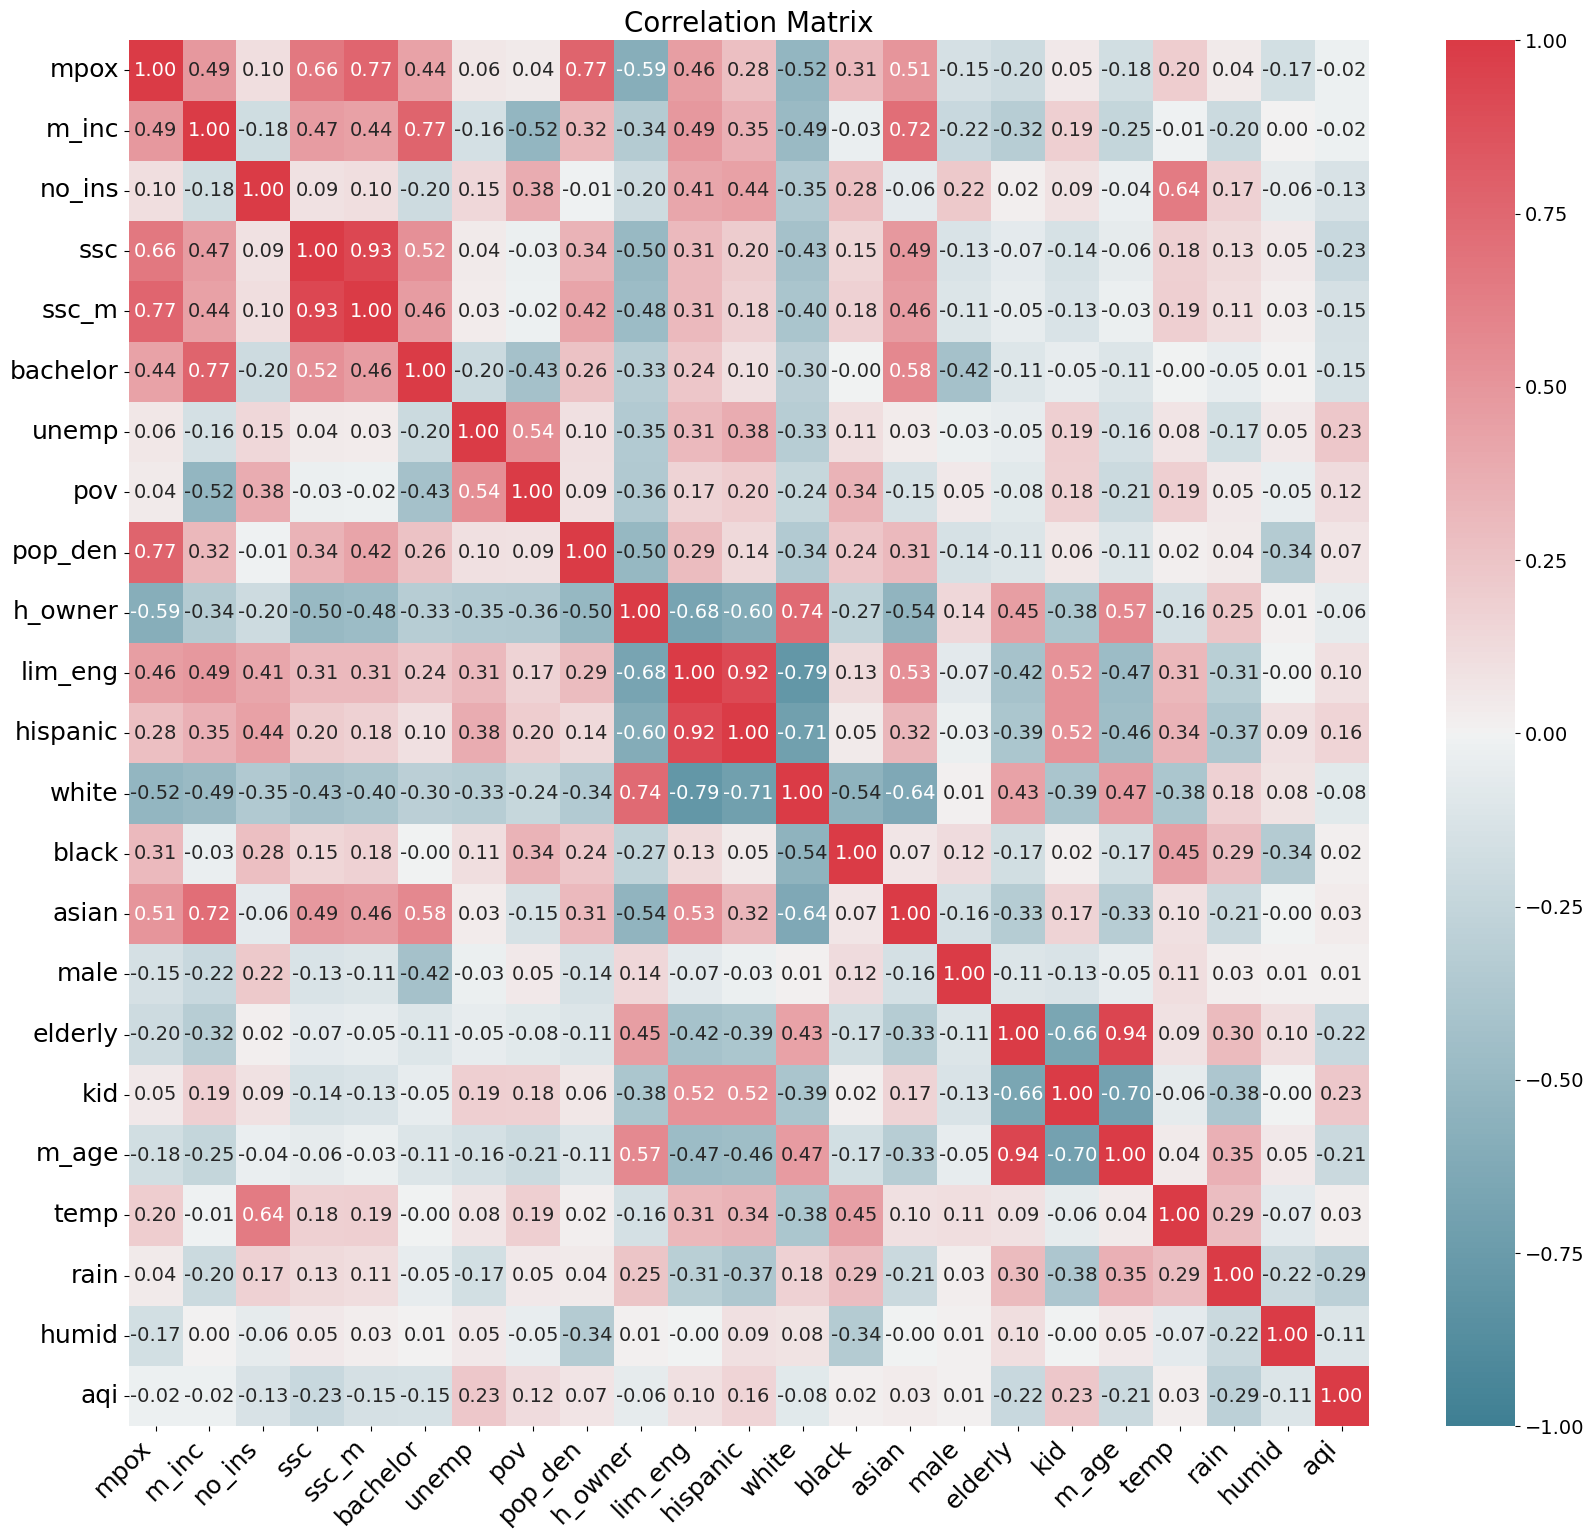

In [420]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Calculate the correlation matrix
corr_matrix = df_var.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(20, 18))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1, vmax=1,
           xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns,annot_kws={"size": 14}, fmt=".2f")

# Enlarge x, y label font sizes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=18, rotation = 45, ha='right')  # Adjust the font size (e.g., 14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=18, rotation=0)  # Adjust the font size (e.g., 14)

# Customize the colorbar (legend) font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14) 

# Add title
plt.title('Correlation Matrix', fontsize=20)  # Adjust the font size (e.g., 16)

# Show the plot
plt.show()

## Bivariate Regression Analysis

Bivariate regression analysis between mpox and explanatory variables

In [421]:
ind_var_ls = copy.deepcopy(col_ls)
ind_var_ls.remove('mpox')


st_ls = ['all','CA','FL','NY','IL','WA']
reg_sum_ls = []
for st in st_ls:
    # Select state
    if st == 'all':
        df2 = df
    elif st != 'all':
        df2 = df[df['state'] == int(us.states.lookup(st).fips)]
    
    df2.drop(columns=['Unnamed: 0','County','fips','state','county'])
    df2 = (df2 - df2.mean()) / df2.std()
    
    coef_ls = []
    p_value_ls = []
    r_squared_ls = []

    for var in ind_var_ls:
        x = df2[[var]]
        y = df2[['mpox']]

        x = sm.add_constant(x)

        model = sm.OLS(y, x).fit()

        # Create a summary table with coefficients, p-values, and adjusted R-squared
        summary_table = model.summary()

        coef_ls.append(model.params[1])
        p_value_ls.append(model.pvalues[1])
        r_squared_ls.append(model.rsquared)
    reg_sum = pd.DataFrame(list(zip(coef_ls, p_value_ls, r_squared_ls)), columns=['Coef','p-value','R2'])
    reg_sum_ls.append(reg_sum)

new_col = pd.DataFrame({'Variable': ind_var_ls})

reg_sum_ls.insert(0, new_col)

reg_sum_all = pd.concat(reg_sum_ls, axis=1)

reg_sum_all.to_excel('../Table/univar_reg_result.xlsx', index=False)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\3665148052.py:15: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2 = (df2 - df2.mean()) / df2.std()
C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\3665148052.py:15: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2 = (df2 - df2.mean()) / df2.std()
C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\3665148052.py:15: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_on

## Multivariate Regression Analysis

Regression analysis of all counties in 5 states

In [422]:
# X = df_var[['m_inc', 'no_ins', 'ssc', 'ssc_m', 'bachelor', 'unemp', 'pov',
#        'h_owner', 'lim_eng', 'hispanic', 'white', 'black', 'asian', 'male',
#        'elderly', 'kid', 'm_age', 'temp', 'rain', 'humid', 'aqi', 'pop_den']]

# Removed 'm_inc', 'ssc', 'lim_eng', 'white', 'm_age'
short_var_ls = ['no_ins', 'ssc_m', 'bachelor', 'unemp', 'pov', 'pop_den',
       'h_owner', 'hispanic','black', 'asian', 'male',
       'elderly', 'kid', 'temp', 'rain', 'humid', 'aqi']



X = df_var[short_var_ls]       # Select columns
X = (X - X.mean()) / X.std()   # Standardize variables

y = df_var[['mpox']]           # Select columns
y = (y - y.mean()) / y.std()   # Standardize variables

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
         
# Create a summary table with coefficients, p-values, and adjusted R-squared
summary_table = model.summary()

# Display the summary table
print(summary_table)

with open('../Table/reg_result_all_states.csv', 'w') as f:
    f.write(summary_table.as_csv())

                            OLS Regression Results                            
Dep. Variable:                   mpox   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     112.2
Date:                Thu, 09 Nov 2023   Prob (F-statistic):          1.38e-120
Time:                        17:10:19   Log-Likelihood:                -139.58
No. Observations:                 325   AIC:                             315.2
Df Residuals:                     307   BIC:                             383.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.469e-17      0.021  -1.64e-15      1.0

#### Calculate VIF of independent variables

In [423]:
# Calculate VIF for each independent variable
vif_data = pd.DataFrame()

vif_data["features"] = X.columns

vif_data["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
vif_data.round(1)


,features,VIF Factor
0,const,1.0
1,no_ins,2.8
2,ssc_m,1.9
3,bachelor,3.0
4,unemp,1.8
5,pov,2.9
6,pop_den,1.9
7,h_owner,4.5
8,hispanic,3.5
9,black,1.9


#### Run multivariate regression in all states

In [424]:
st_ls = ['all','CA','FL','NY','IL','WA']

for st in st_ls:
    # Select state
    if st == 'all':
        df2 = df
    elif st != 'all':
        df2 = df[df['state'] == int(us.states.lookup(st).fips)]
        
    # drop unwanted columns
    df2 = df2.drop(columns=['Unnamed: 0','County','fips','state','county'])
    
    # Standardize variables
    df2 = (df2 - df2.mean()) / df2.std()
    
    # reorganize columns
    df2 = df2[col_ls]

    X = df2[short_var_ls]

    y = df2[['mpox']]
    
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    # Create a summary table with coefficients, p-values, and adjusted R-squared
    summary_table = model.summary()

    # Display the summary table
    print(summary_table)

    with open('../Table/reg_result_{}.csv'.format(st), 'w') as f:
        f.write(summary_table.as_csv())

                            OLS Regression Results                            
Dep. Variable:                   mpox   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     112.2
Date:                Thu, 09 Nov 2023   Prob (F-statistic):          1.38e-120
Time:                        17:10:19   Log-Likelihood:                -139.58
No. Observations:                 325   AIC:                             315.2
Df Residuals:                     307   BIC:                             383.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.939e-18      0.021   3.27e-16      1.0

## Spatial Lag Model

In [466]:
df = df.drop('Unnamed: 0', axis=1)

KeyError: "['Unnamed: 0'] not found in axis"

In [467]:
gdf = gpd.read_file('../MyProject15/tl_2021_us_county.shp')
gdf = gdf[['GEOID','geometry']].rename(columns={'GEOID':'fips'})

In [468]:
gdf['fips'] = gdf['fips'].astype(int)
gdf = gdf.merge(df, how='inner', on='fips')

In [474]:
gdf.columns

Index(['fips', 'geometry', 'County', 'mpox', 'no_ins', 'rain', 'pop_den',
       'temp', 'ssc', 'humid', 'aqi', 'ssc_m', 'state', 'county', 'pov',
       'unemp', 'bachelor', 'm_age', 'm_inc', 'kid', 'male', 'white', 'asian',
       'hispanic', 'black', 'elderly', 'h_owner', 'lim_eng'],
      dtype='object')

In [538]:


#st = 'CA'
#gdf2 = gdf[gdf['state'] == int(us.states.lookup(st).fips)]
gdf2 = gdf

# Create the spatial weights matrix, e.g., queen contiguity
w = libpysal.weights.Queen.from_dataframe(gdf2)
# Transform the weights matrix to row-standardize it
w.transform = 'R'

# Specify your dependent variable (y) and independent variables (X)
y_names = ['mpox']
y = gdf2[y_names].values.squeeze()
display(y.shape)
x_names = ['no_ins', 'ssc_m', 'bachelor', 'unemp', 'pov', 'pop_den',
       'h_owner', 'hispanic','black', 'asian', 'male',
       'elderly', 'kid', 'temp', 'rain', 'humid', 'aqi']
X = gdf2[x_names].values
display(X.shape)
# Run the spatial lag model
model = ML_Lag(y, X, w,name_y=y_name,name_x=x_names)
print(model.summary)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\892851392.py:6: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf2)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


(325,)

(325, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       PRICE                Number of Observations:         325
Mean dependent var  :      3.2044                Number of Variables   :          19
S.D. dependent var  :      9.2855                Degrees of Freedom    :         306
Pseudo R-squared    :      0.8614
Spatial Pseudo R-squared:  0.8620
Log likelihood      :   -863.7621
Sigma-square ML     :     11.9115                Akaike info criterion :    1765.524
S.E of regression   :      3.4513                Schwarz criterion     :    1837.417

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

### Spatial Lag Model for each state

In [547]:
st_ls = ['all','CA','FL','NY','IL','WA']

for st in st_ls:
    # Select state
    if st == 'all':
        gdf2 = gdf
    elif st != 'all':
        gdf2 = gdf[gdf['state'] == int(us.states.lookup(st).fips)]
    
    display('============================{}============================'.format(st))
    # Create the spatial weights matrix, e.g., queen contiguity
    # w = libpysal.weights.Queen.from_dataframe(gdf2)
    w = libpysal.weights.KNN.from_dataframe(gdf2, k = 10)
    # Transform the weights matrix to row-standardize it
    w.transform = 'R'

    # Specify your dependent variable (y) and independent variables (X)
    y_names = ['mpox']
    y = gdf2[y_names].values.squeeze()
    display(y.shape)
    x_names = ['no_ins', 'ssc_m', 'bachelor', 'unemp', 'pov', 'pop_den',
           'h_owner', 'hispanic','black', 'asian', 'male',
           'elderly', 'kid', 'temp', 'rain', 'humid', 'aqi']
    X = gdf2[x_names].values
    display(X.shape)
    # Run the spatial lag model
    model = ML_Lag(y, X, w,name_y=y_name,name_x=x_names)
    print(model.summary)

'============================all============================'

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


(325,)

(325, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       PRICE                Number of Observations:         325
Mean dependent var  :      3.2044                Number of Variables   :          19
S.D. dependent var  :      9.2855                Degrees of Freedom    :         306
Pseudo R-squared    :      0.8629
Spatial Pseudo R-squared:  0.8643
Log likelihood      :   -862.1820
Sigma-square ML     :     11.7869                Akaike info criterion :    1762.364
S.E of regression   :      3.4332                Schwarz criterion     :    1834.257

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

'============================CA============================'

(58,)

(58, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       PRICE                Number of Observations:          58
Mean dependent var  :      5.1155                Number of Variables   :          19
S.D. dependent var  :     12.7053                Degrees of Freedom    :          39
Pseudo R-squared    :      0.9714
Spatial Pseudo R-squared:  0.9709
Log likelihood      :   -126.2188
Sigma-square ML     :      4.5425                Akaike info criterion :     290.438
S.E of regression   :      2.1313                Schwarz criterion     :     329.586

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

'============================FL============================'

(67,)

(67, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       PRICE                Number of Observations:          67
Mean dependent var  :      4.7773                Number of Variables   :          19
S.D. dependent var  :      8.1564                Degrees of Freedom    :          48
Pseudo R-squared    :      0.8535
Spatial Pseudo R-squared:  0.8543
Log likelihood      :   -170.9065
Sigma-square ML     :      9.6008                Akaike info criterion :     379.813
S.E of regression   :      3.0985                Schwarz criterion     :     421.702

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

'============================NY============================'

(60,)

(60, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       PRICE                Number of Observations:          60
Mean dependent var  :      4.7147                Number of Variables   :          19
S.D. dependent var  :     14.2170                Degrees of Freedom    :          41
Pseudo R-squared    :      0.9908
Spatial Pseudo R-squared:  0.9907
Log likelihood      :   -103.3955
Sigma-square ML     :      1.8378                Akaike info criterion :     244.791
S.E of regression   :      1.3556                Schwarz criterion     :     284.584

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

'============================IL============================'

(101,)

(101, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       PRICE                Number of Observations:         101
Mean dependent var  :      0.7840                Number of Variables   :          19
S.D. dependent var  :      2.6757                Degrees of Freedom    :          82
Pseudo R-squared    :      0.8027
Spatial Pseudo R-squared:  0.7779
Log likelihood      :   -161.7027
Sigma-square ML     :      1.3990                Akaike info criterion :     361.405
S.E of regression   :      1.1828                Schwarz criterion     :     411.093

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

'============================WA============================'

(39,)

(39, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       PRICE                Number of Observations:          39
Mean dependent var  :      1.6044                Number of Variables   :          19
S.D. dependent var  :      3.6145                Degrees of Freedom    :          20
Pseudo R-squared    :      0.8675
Spatial Pseudo R-squared:  0.8590
Log likelihood      :    -65.6716
Sigma-square ML     :      1.6870                Akaike info criterion :     169.343
S.E of regression   :      1.2988                Schwarz criterion     :     200.951

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

### OLS Model of each state

In [543]:
st_ls = ['all','CA','FL','NY','IL','WA']

for st in st_ls:
    # Select state
    if st == 'all':
        gdf2 = gdf
    elif st != 'all':
        gdf2 = gdf[gdf['state'] == int(us.states.lookup(st).fips)]
    
    
    display('============================{}============================'.format(st))

    # Create the spatial weights matrix, e.g., queen contiguity
    w = libpysal.weights.Queen.from_dataframe(gdf2)
    # Transform the weights matrix to row-standardize it
    w.transform = 'R'

    # Specify your dependent variable (y) and independent variables (X)
    y_names = ['mpox']
    y = gdf2[y_names].values.squeeze()
    display(y.shape)
    x_names = ['no_ins', 'ssc_m', 'bachelor', 'unemp', 'pov', 'pop_den',
           'h_owner', 'hispanic','black', 'asian', 'male',
           'elderly', 'kid', 'temp', 'rain', 'humid', 'aqi']
    X = gdf2[x_names].values
    display(X.shape)
    # Run the spatial lag model
    model = OLS(y, X, name_y=y_name,name_x=x_names)
    print(model.summary)

'============================all============================'

C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\2299148172.py:14: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf2)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


(325,)

(325, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :       PRICE                Number of Observations:         325
Mean dependent var  :      3.2044                Number of Variables   :          18
S.D. dependent var  :      9.2855                Degrees of Freedom    :         307
R-squared           :      0.8614
Adjusted R-squared  :      0.8537
Sum squared residual:     3873.24                F-statistic           :    112.1902
Sigma-square        :      12.616                Prob(F-statistic)     :  1.376e-120
S.E. of regression  :       3.552                Log likelihood        :    -863.833
Sigma-square ML     :      11.918                Akaike info criterion :    1763.667
S.E of regression ML:      3.4522                Schwarz criterion     :    1831.776

------------------------------------------------------------

'============================CA============================'

C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\2299148172.py:14: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf2)


(58,)

(58, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :       PRICE                Number of Observations:          58
Mean dependent var  :      5.1155                Number of Variables   :          18
S.D. dependent var  :     12.7053                Degrees of Freedom    :          40
R-squared           :      0.9708
Adjusted R-squared  :      0.9584
Sum squared residual:     268.745                F-statistic           :     78.2061
Sigma-square        :       6.719                Prob(F-statistic)     :   2.776e-25
S.E. of regression  :       2.592                Log likelihood        :    -126.765
Sigma-square ML     :       4.634                Akaike info criterion :     289.529
S.E of regression ML:      2.1526                Schwarz criterion     :     326.617

------------------------------------------------------------

'============================FL============================'

C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\2299148172.py:14: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf2)


(67,)

(67, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :       PRICE                Number of Observations:          67
Mean dependent var  :      4.7773                Number of Variables   :          18
S.D. dependent var  :      8.1564                Degrees of Freedom    :          49
R-squared           :      0.8522
Adjusted R-squared  :      0.8009
Sum squared residual:     648.959                F-statistic           :     16.6195
Sigma-square        :      13.244                Prob(F-statistic)     :   8.751e-15
S.E. of regression  :       3.639                Log likelihood        :    -171.137
Sigma-square ML     :       9.686                Akaike info criterion :     378.273
S.E of regression ML:      3.1122                Schwarz criterion     :     417.958

------------------------------------------------------------

'============================NY============================'

C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\2299148172.py:14: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf2)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


(60,)

(60, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :       PRICE                Number of Observations:          60
Mean dependent var  :      4.7147                Number of Variables   :          18
S.D. dependent var  :     14.2170                Degrees of Freedom    :          42
R-squared           :      0.9907
Adjusted R-squared  :      0.9870
Sum squared residual:     110.696                F-statistic           :    263.6870
Sigma-square        :       2.636                Prob(F-statistic)     :   4.465e-37
S.E. of regression  :       1.623                Log likelihood        :    -103.510
Sigma-square ML     :       1.845                Akaike info criterion :     243.019
S.E of regression ML:      1.3583                Schwarz criterion     :     280.717

------------------------------------------------------------

'============================IL============================'

C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\2299148172.py:14: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf2)


(101,)

(101, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :       PRICE                Number of Observations:         101
Mean dependent var  :      0.7840                Number of Variables   :          18
S.D. dependent var  :      2.6757                Degrees of Freedom    :          83
R-squared           :      0.7771
Adjusted R-squared  :      0.7315
Sum squared residual:     159.576                F-statistic           :     17.0224
Sigma-square        :       1.923                Prob(F-statistic)     :   2.811e-20
S.E. of regression  :       1.387                Log likelihood        :    -166.411
Sigma-square ML     :       1.580                Akaike info criterion :     368.823
S.E of regression ML:      1.2570                Schwarz criterion     :     415.895

------------------------------------------------------------

'============================WA============================'

C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\2299148172.py:14: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf2)


(39,)

(39, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :       PRICE                Number of Observations:          39
Mean dependent var  :      1.6044                Number of Variables   :          18
S.D. dependent var  :      3.6145                Degrees of Freedom    :          21
R-squared           :      0.8615
Adjusted R-squared  :      0.7493
Sum squared residual:     68.7816                F-statistic           :      7.6806
Sigma-square        :       3.275                Prob(F-statistic)     :   1.354e-05
S.E. of regression  :       1.810                Log likelihood        :     -66.402
Sigma-square ML     :       1.764                Akaike info criterion :     168.805
S.E of regression ML:      1.3280                Schwarz criterion     :     198.749

------------------------------------------------------------

## Spatial Error Model

In [544]:
st_ls = ['all','CA','FL','NY','IL','WA']

for st in st_ls:
    # Select state
    if st == 'all':
        gdf2 = gdf
    elif st != 'all':
        gdf2 = gdf[gdf['state'] == int(us.states.lookup(st).fips)]

    # Create the spatial weights matrix, e.g., queen contiguity
    w = libpysal.weights.Queen.from_dataframe(gdf2)
    # Transform the weights matrix to row-standardize it
    w.transform = 'R'

    # Specify your dependent variable (y) and independent variables (X)
    y_names = ['mpox']
    y = gdf2[y_names].values.squeeze()
    display(y.shape)
    x_names = ['no_ins', 'ssc_m', 'bachelor', 'unemp', 'pov', 'pop_den',
           'h_owner', 'hispanic','black', 'asian', 'male',
           'elderly', 'kid', 'temp', 'rain', 'humid', 'aqi']
    X = gdf2[x_names].values
    display(X.shape)
    # Run the spatial lag model
    SEM = ML_Error(y, X,w, name_y=y_name,name_x=x_names)
    print(SEM.summary)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\1520383277.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf2)
C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


(325,)

(325, 17)

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\1520383277.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf2)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       PRICE                Number of Observations:         325
Mean dependent var  :      3.2044                Number of Variables   :          18
S.D. dependent var  :      9.2855                Degrees of Freedom    :         307
Pseudo R-squared    :      0.8601
Log likelihood      :   -858.7093
Sigma-square ML     :     11.3439                Akaike info criterion :    1753.419
S.E of regression   :      3.3681                Schwarz criterion     :    1821.527

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -5.19509    

(58,)

(58, 17)

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\1520383277.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf2)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       PRICE                Number of Observations:          58
Mean dependent var  :      5.1155                Number of Variables   :          18
S.D. dependent var  :     12.7053                Degrees of Freedom    :          40
Pseudo R-squared    :      0.9611
Log likelihood      :   -122.5178
Sigma-square ML     :      3.2860                Akaike info criterion :     281.036
S.E of regression   :      1.8127                Schwarz criterion     :     318.123

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -1.16886    

(67,)

(67, 17)

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\1520383277.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf2)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       PRICE                Number of Observations:          67
Mean dependent var  :      4.7773                Number of Variables   :          18
S.D. dependent var  :      8.1564                Degrees of Freedom    :          49
Pseudo R-squared    :      0.8521
Log likelihood      :   -171.1204
Sigma-square ML     :      9.6772                Akaike info criterion :     378.241
S.E of regression   :      3.1108                Schwarz criterion     :     417.925

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        48.10840    

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


(60,)

(60, 17)

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\1520383277.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf2)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       PRICE                Number of Observations:          60
Mean dependent var  :      4.7147                Number of Variables   :          18
S.D. dependent var  :     14.2170                Degrees of Freedom    :          42
Pseudo R-squared    :      0.9906
Log likelihood      :   -103.1526
Sigma-square ML     :      1.7998                Akaike info criterion :     242.305
S.E of regression   :      1.3416                Schwarz criterion     :     280.003

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -3.94460    

(101,)

(101, 17)

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\qiangy\AppData\Local\Temp\ipykernel_64532\1520383277.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf2)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       PRICE                Number of Observations:         101
Mean dependent var  :      0.7840                Number of Variables   :          18
S.D. dependent var  :      2.6757                Degrees of Freedom    :          83
Pseudo R-squared    :      0.7505
Log likelihood      :   -154.4451
Sigma-square ML     :      1.0356                Akaike info criterion :     344.890
S.E of regression   :      1.0177                Schwarz criterion     :     391.962

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        12.50352    

(39,)

(39, 17)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       PRICE                Number of Observations:          39
Mean dependent var  :      1.6044                Number of Variables   :          18
S.D. dependent var  :      3.6145                Degrees of Freedom    :          21
Pseudo R-squared    :      0.8415
Log likelihood      :    -64.2056
Sigma-square ML     :      1.3250                Akaike info criterion :     164.411
S.E of regression   :      1.1511                Schwarz criterion     :     194.355

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        65.86351    

C:\ProgramData\Anaconda3\envs\geo2\Lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
